# EEG Data Preprocessing and Visualization

This notebook loads, preprocesses, and visualizes EEG data for the LIINC project.

**Data Structure:**
- EEG arrays: 20 channels × 512 time points
- Two time windows: `review_eeg` (decision period) and `baseline_eeg` (baseline period)
- Linked to trials via `subject_date_id` and `trial_id`

In [3]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal, stats
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)
sns.set_style('whitegrid')

## 1. Load Raw EEG Data

In [4]:
# Load EEG data
with open('../../data/eeg/preprocessed_eeg_10_subjects_pre.pkl', 'rb') as f:
    eeg_df = pickle.load(f)

print(f"✓ Loaded EEG data: {len(eeg_df)} trials")
print(f"  Columns: {eeg_df.columns.tolist()}")
print(f"  Unique subjects: {eeg_df['subject_date_id'].nunique()}")
print(f"\nSample EEG shapes:")
print(f"  review_eeg: {np.array(eeg_df['review_eeg'].iloc[0]).shape}")
print(f"  baseline_eeg: {np.array(eeg_df['baseline_eeg'].iloc[0]).shape}")

eeg_df.head()

✓ Loaded EEG data: 1287 trials
  Columns: ['subject_date_id', 'trial_id', 'review_eeg', 'baseline_eeg']
  Unique subjects: 10

Sample EEG shapes:
  review_eeg: (20, 512)
  baseline_eeg: (20, 512)


,subject_date_id,trial_id,review_eeg,baseline_eeg
0,0831_1300_9M4VCHG,0,"[[-0.0002836831199088289, -0.01197354425743936...","[[-0.0002836831199088289, -0.01197354425743936..."
1,0831_1300_9M4VCHG,1,"[[-0.03199403386188704, -0.028824994983213243,...","[[-0.03199403386188704, -0.028824994983213243,..."
2,0831_1300_9M4VCHG,2,"[[-0.029377957230920602, -0.02182500204761463,...","[[-0.029377957230920602, -0.02182500204761463,..."
3,0831_1300_9M4VCHG,3,"[[-0.031175495217342537, -0.03537368531109756,...","[[-0.031175495217342537, -0.03537368531109756,..."
4,0831_1300_9M4VCHG,4,"[[0.015509465169587436, 0.007873909722144426, ...","[[0.015509465169587436, 0.007873909722144426, ..."


## 2. EEG Channel Information

Standard 10-20 EEG channel names (20 channels)

In [5]:
# Common 20-channel EEG montage (10-20 system)
channel_names = [
    'Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8',
    'T3', 'C3', 'Cz', 'C4', 'T4',
    'T5', 'P3', 'Pz', 'P4', 'T6',
    'O1', 'Oz', 'O2'
]

# Channel regions
channel_regions = {
    'Frontal': ['Fp1', 'Fp2', 'F7', 'F3', 'Fz', 'F4', 'F8'],
    'Central': ['T3', 'C3', 'Cz', 'C4', 'T4'],
    'Parietal': ['T5', 'P3', 'Pz', 'P4', 'T6'],
    'Occipital': ['O1', 'Oz', 'O2']
}

print("EEG Channels by Region:")
for region, channels in channel_regions.items():
    print(f"  {region}: {', '.join(channels)}")

EEG Channels by Region:
  Frontal: Fp1, Fp2, F7, F3, Fz, F4, F8
  Central: T3, C3, Cz, C4, T4
  Parietal: T5, P3, Pz, P4, T6
  Occipital: O1, Oz, O2


## 3. Visualize Raw EEG Signals

In [6]:
# Select a trial to visualize
trial_idx = 0
review_eeg = np.array(eeg_df['review_eeg'].iloc[trial_idx])  # (20, 512)
baseline_eeg = np.array(eeg_df['baseline_eeg'].iloc[trial_idx])  # (20, 512)

# Assume sampling rate (common for EEG)
fs = 256  # Hz
n_timepoints = review_eeg.shape[1]
time = np.arange(n_timepoints) / fs

print(f"Trial {trial_idx} - Subject: {eeg_df['subject_date_id'].iloc[trial_idx]}")
print(f"Time window: {time[-1]:.2f} seconds")
print(f"Sampling rate: {fs} Hz")

Trial 0 - Subject: 0831_1300_9M4VCHG
Time window: 2.00 seconds
Sampling rate: 256 Hz


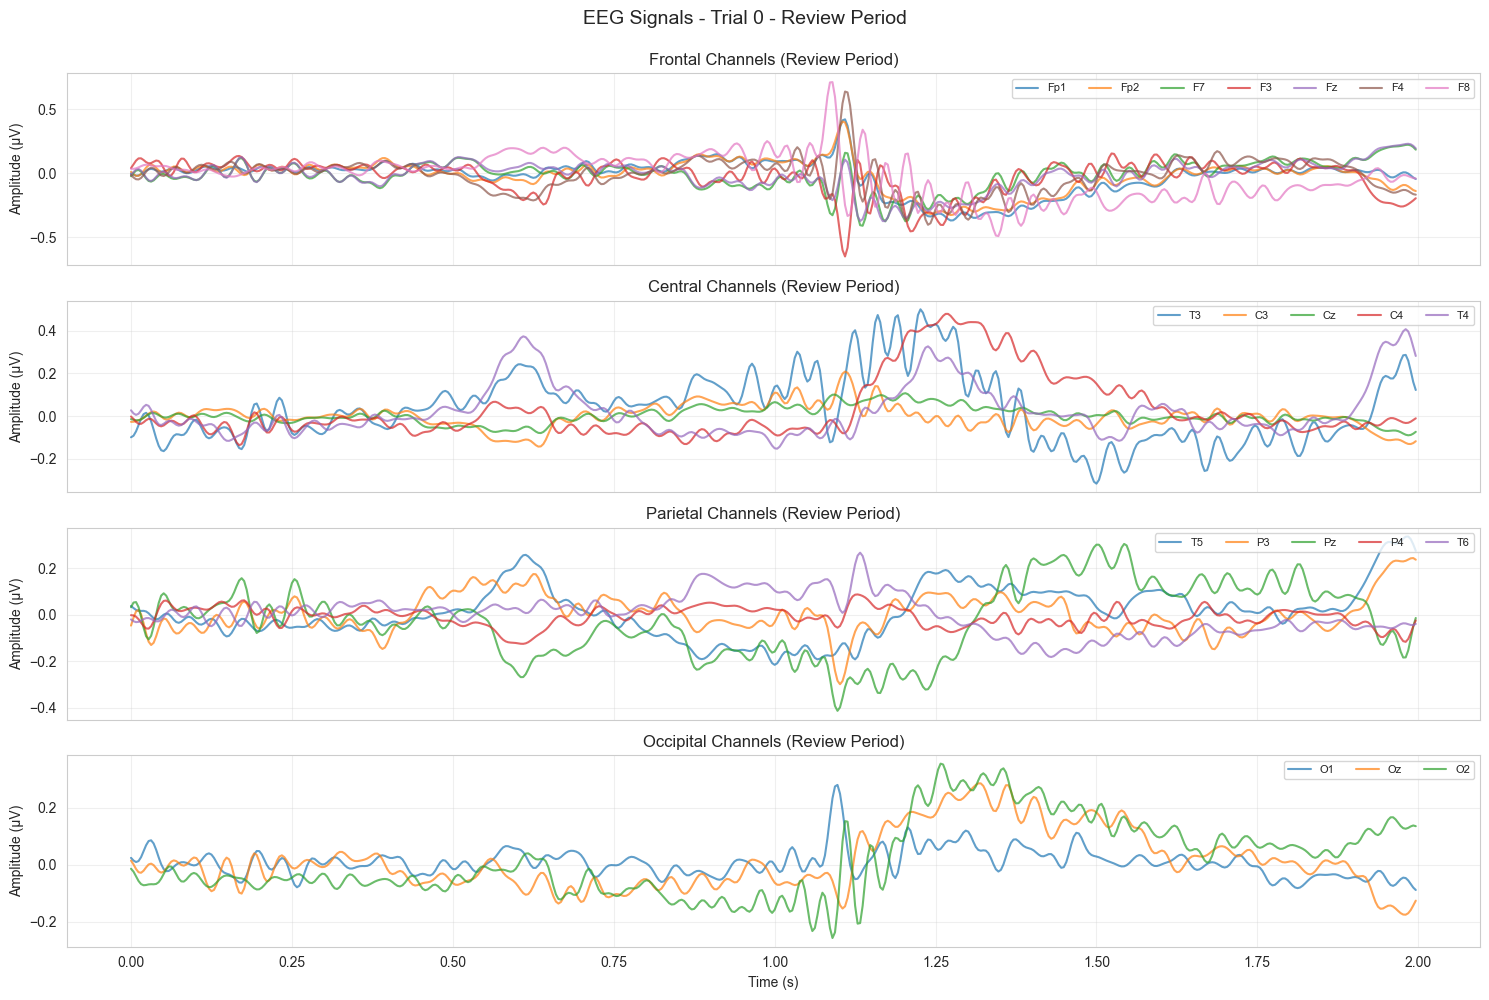

In [7]:
# Plot all channels for review period
fig, axes = plt.subplots(4, 1, figsize=(15, 10), sharex=True)

for idx, (region, channels) in enumerate(channel_regions.items()):
    ax = axes[idx]
    
    # Plot channels in this region
    for ch_name in channels:
        ch_idx = channel_names.index(ch_name)
        ax.plot(time, review_eeg[ch_idx, :], alpha=0.7, label=ch_name)
    
    ax.set_ylabel('Amplitude (µV)')
    ax.set_title(f'{region} Channels (Review Period)')
    ax.legend(loc='upper right', ncol=len(channels), fontsize=8)
    ax.grid(alpha=0.3)

axes[-1].set_xlabel('Time (s)')
plt.suptitle(f'EEG Signals - Trial {trial_idx} - Review Period', fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

## 4. Baseline vs Review Period Comparison

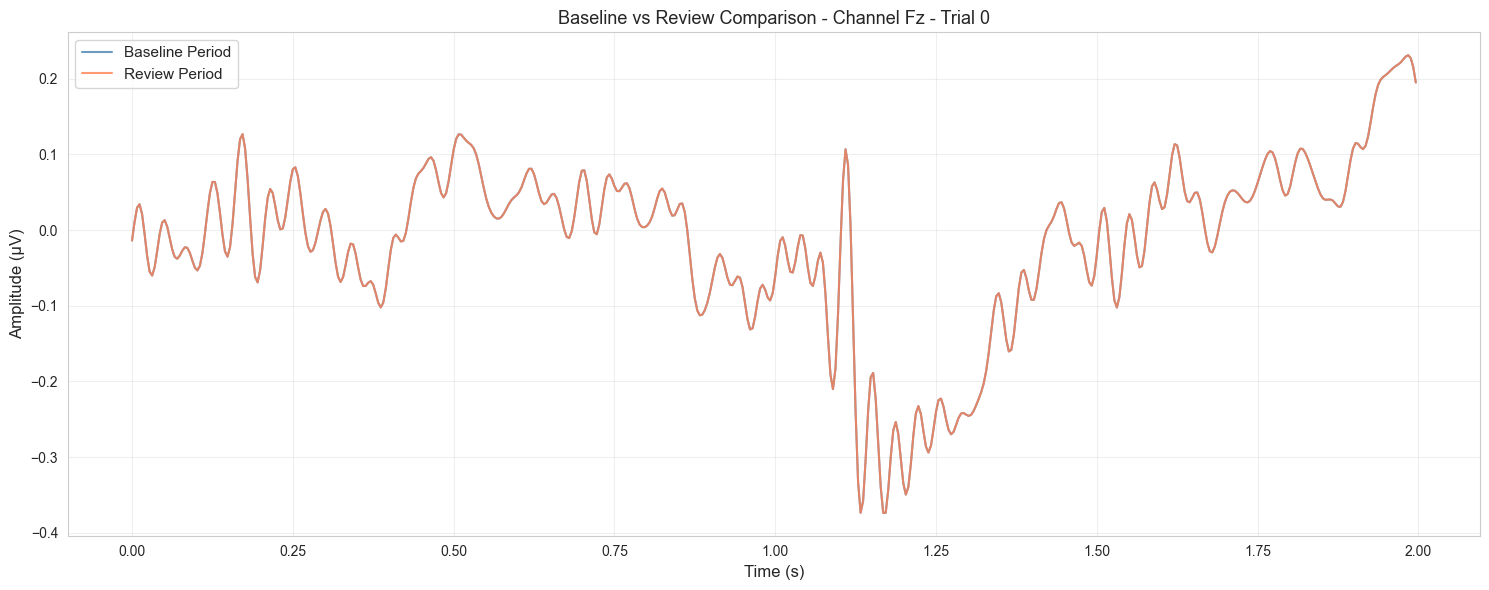

In [8]:
# Compare baseline and review for a single channel
channel_idx = channel_names.index('Fz')  # Frontal midline

fig, ax = plt.subplots(1, 1, figsize=(15, 6))

# Plot both on same axes
ax.plot(time, baseline_eeg[channel_idx, :], color='steelblue', linewidth=1.5, 
        label='Baseline Period', alpha=0.8)
ax.plot(time, review_eeg[channel_idx, :], color='coral', linewidth=1.5, 
        label='Review Period', alpha=0.8)

ax.set_ylabel('Amplitude (µV)', fontsize=12)
ax.set_xlabel('Time (s)', fontsize=12)
ax.set_title(f'Baseline vs Review Comparison - Channel {channel_names[channel_idx]} - Trial {trial_idx}', 
             fontsize=13)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Power Spectral Density (PSD) Analysis

In [9]:
# Define frequency bands
freq_bands = {
    'Delta': (0.5, 4),
    'Theta': (4, 8),
    'Alpha': (8, 13),
    'Beta': (13, 30),
    'Gamma': (30, 50)
}

def compute_psd(eeg_data, fs=256):
    """
    Compute Power Spectral Density for all channels.
    
    Args:
        eeg_data: (n_channels, n_timepoints)
        fs: sampling rate in Hz
    
    Returns:
        freqs: frequency array
        psd: power spectral density (n_channels, n_freqs)
    """
    freqs, psd = signal.welch(eeg_data, fs=fs, nperseg=min(256, eeg_data.shape[1]))
    return freqs, psd

# Compute PSD for review and baseline
freqs, psd_review = compute_psd(review_eeg, fs)
_, psd_baseline = compute_psd(baseline_eeg, fs)

print(f"Frequency range: {freqs[0]:.2f} - {freqs[-1]:.2f} Hz")
print(f"PSD shape: {psd_review.shape}")

Frequency range: 0.00 - 128.00 Hz
PSD shape: (20, 129)


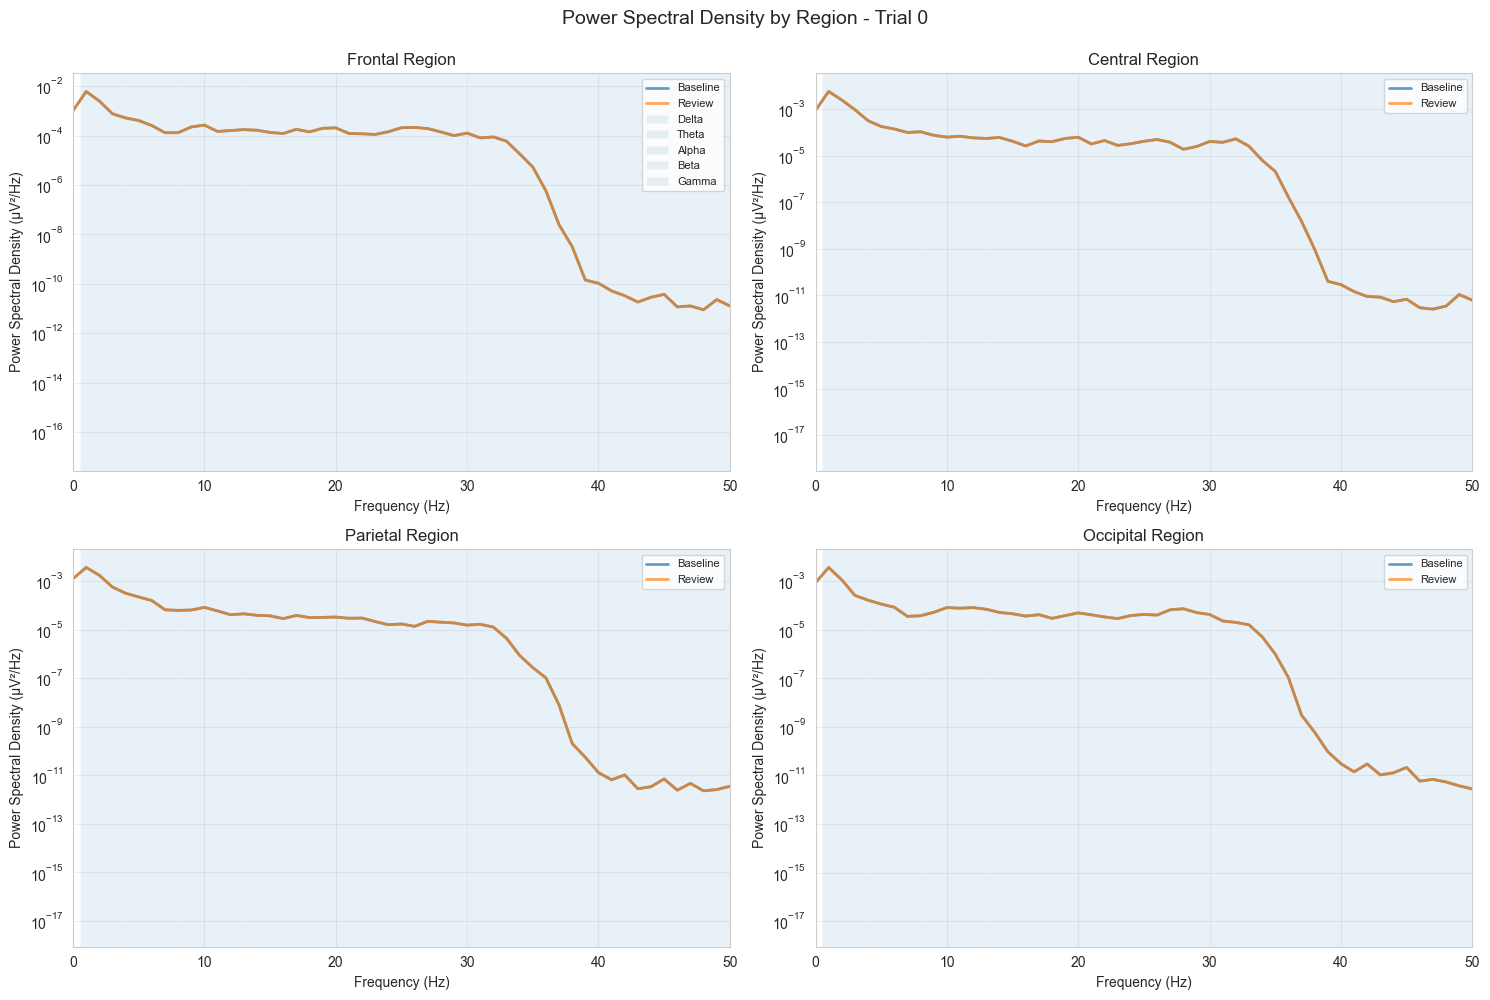

In [10]:
# Plot PSD for each region (averaged across channels)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for idx, (region, channels) in enumerate(channel_regions.items()):
    ax = axes[idx]
    
    # Get channel indices for this region
    ch_indices = [channel_names.index(ch) for ch in channels]
    
    # Average PSD across channels in this region
    psd_review_region = np.mean(psd_review[ch_indices, :], axis=0)
    psd_baseline_region = np.mean(psd_baseline[ch_indices, :], axis=0)
    
    # Plot
    ax.semilogy(freqs, psd_baseline_region, label='Baseline', alpha=0.7, linewidth=2)
    ax.semilogy(freqs, psd_review_region, label='Review', alpha=0.7, linewidth=2)
    
    # Mark frequency bands
    for band_name, (f_low, f_high) in freq_bands.items():
        ax.axvspan(f_low, f_high, alpha=0.1, label=band_name if idx == 0 else '')
    
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Power Spectral Density (µV²/Hz)')
    ax.set_title(f'{region} Region')
    ax.set_xlim([0, 50])
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)

plt.suptitle(f'Power Spectral Density by Region - Trial {trial_idx}', fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

## 6. Extract Band Power Features

In [11]:
def compute_band_power(eeg_data, fs=256, bands=None):
    """
    Compute band power for each channel and frequency band.
    
    Args:
        eeg_data: (n_channels, n_timepoints)
        fs: sampling rate
        bands: dict of {band_name: (f_low, f_high)}
    
    Returns:
        band_powers: dict of {band_name: array of shape (n_channels,)}
    """
    if bands is None:
        bands = freq_bands
    
    freqs, psd = compute_psd(eeg_data, fs)
    
    band_powers = {}
    for band_name, (f_low, f_high) in bands.items():
        # Find frequency indices
        freq_mask = (freqs >= f_low) & (freqs <= f_high)
        
        # Integrate power in this band
        band_power = np.trapz(psd[:, freq_mask], freqs[freq_mask], axis=1)
        band_powers[band_name] = band_power
    
    return band_powers

# Compute band powers for review and baseline
bp_review = compute_band_power(review_eeg, fs)
bp_baseline = compute_band_power(baseline_eeg, fs)

print("Band Powers (Review Period):")
for band_name, powers in bp_review.items():
    print(f"  {band_name}: mean={np.mean(powers):.3e}, std={np.std(powers):.3e}")

Band Powers (Review Period):
  Delta: mean=5.495e-03, std=3.357e-03
  Theta: mean=7.609e-04, std=4.750e-04
  Alpha: mean=5.479e-04, std=4.796e-04
  Beta: mean=1.332e-03, std=1.603e-03
  Gamma: mean=1.708e-04, std=2.457e-04


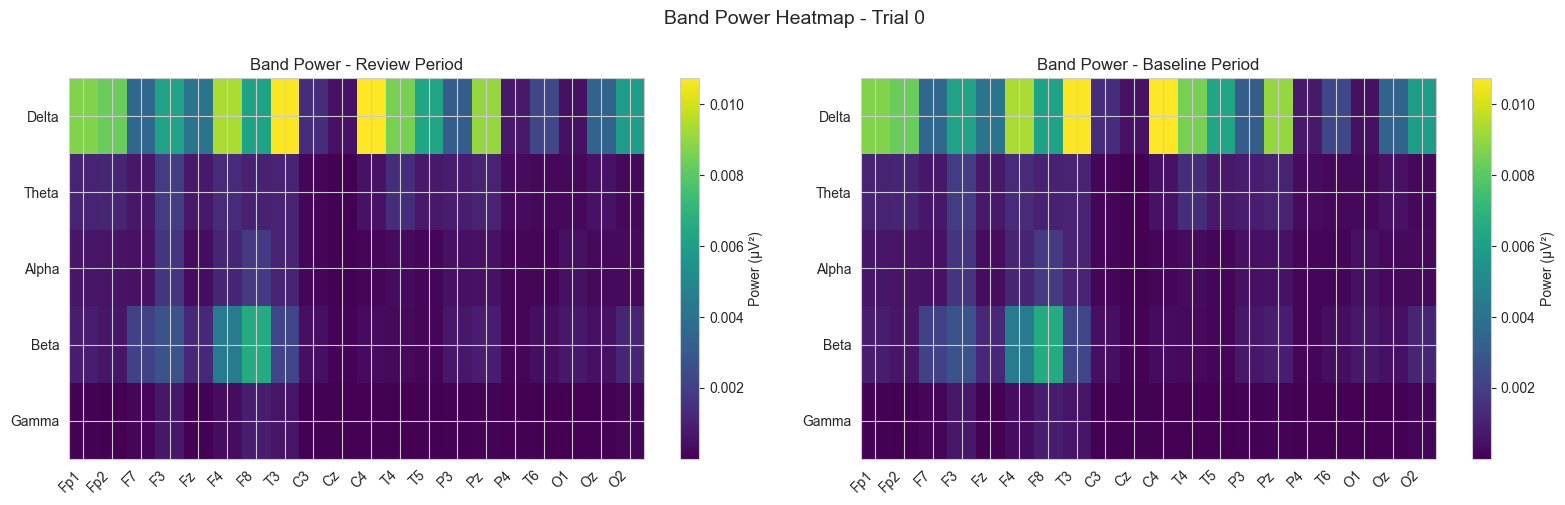

In [12]:
# Visualize band powers across channels
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Review period
ax = axes[0]
band_power_matrix = np.array([bp_review[band] for band in freq_bands.keys()])
im = ax.imshow(band_power_matrix, aspect='auto', cmap='viridis')
ax.set_yticks(range(len(freq_bands)))
ax.set_yticklabels(freq_bands.keys())
ax.set_xticks(range(len(channel_names)))
ax.set_xticklabels(channel_names, rotation=45, ha='right')
ax.set_title('Band Power - Review Period')
plt.colorbar(im, ax=ax, label='Power (µV²)')

# Baseline period
ax = axes[1]
band_power_matrix_bl = np.array([bp_baseline[band] for band in freq_bands.keys()])
im = ax.imshow(band_power_matrix_bl, aspect='auto', cmap='viridis')
ax.set_yticks(range(len(freq_bands)))
ax.set_yticklabels(freq_bands.keys())
ax.set_xticks(range(len(channel_names)))
ax.set_xticklabels(channel_names, rotation=45, ha='right')
ax.set_title('Band Power - Baseline Period')
plt.colorbar(im, ax=ax, label='Power (µV²)')

plt.suptitle(f'Band Power Heatmap - Trial {trial_idx}', fontsize=14, y=1.00)
plt.tight_layout()
plt.show()

## 7. Baseline-Corrected Features

In [13]:
# Compute baseline-corrected band power (relative change)
bp_corrected = {}
for band_name in freq_bands.keys():
    # Relative change: (review - baseline) / baseline
    bp_corrected[band_name] = (bp_review[band_name] - bp_baseline[band_name]) / (bp_baseline[band_name] + 1e-10)

print("Baseline-Corrected Band Powers (% change):")
for band_name, powers in bp_corrected.items():
    print(f"  {band_name}: mean={np.mean(powers)*100:.2f}%, std={np.std(powers)*100:.2f}%")

Baseline-Corrected Band Powers (% change):
  Delta: mean=0.00%, std=0.00%
  Theta: mean=0.00%, std=0.00%
  Alpha: mean=0.00%, std=0.00%
  Beta: mean=0.00%, std=0.00%
  Gamma: mean=0.00%, std=0.00%


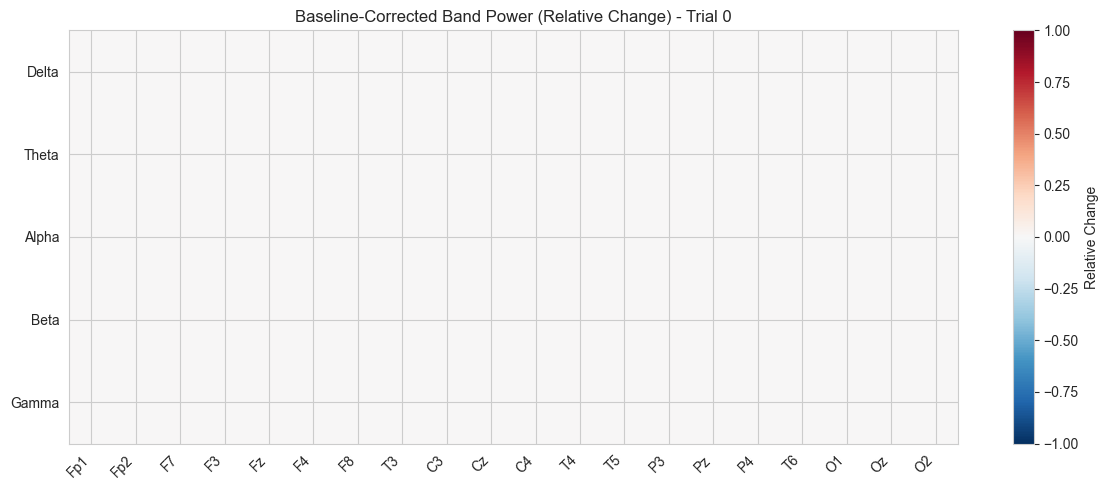

In [14]:
# Visualize baseline-corrected band powers
fig, ax = plt.subplots(figsize=(12, 5))

band_power_corrected_matrix = np.array([bp_corrected[band] for band in freq_bands.keys()])
im = ax.imshow(band_power_corrected_matrix, aspect='auto', cmap='RdBu_r', vmin=-1, vmax=1)
ax.set_yticks(range(len(freq_bands)))
ax.set_yticklabels(freq_bands.keys())
ax.set_xticks(range(len(channel_names)))
ax.set_xticklabels(channel_names, rotation=45, ha='right')
ax.set_title(f'Baseline-Corrected Band Power (Relative Change) - Trial {trial_idx}')
plt.colorbar(im, ax=ax, label='Relative Change')
plt.tight_layout()
plt.show()

## 8. Topographic Maps

In [15]:
# Simplified 2D electrode positions (approximate 10-20 layout)
# These are normalized x, y coordinates for visualization
electrode_positions = {
    'Fp1': (-0.3, 0.9), 'Fp2': (0.3, 0.9),
    'F7': (-0.7, 0.5), 'F3': (-0.4, 0.5), 'Fz': (0, 0.5), 'F4': (0.4, 0.5), 'F8': (0.7, 0.5),
    'T3': (-0.9, 0), 'C3': (-0.4, 0), 'Cz': (0, 0), 'C4': (0.4, 0), 'T4': (0.9, 0),
    'T5': (-0.7, -0.5), 'P3': (-0.4, -0.5), 'Pz': (0, -0.5), 'P4': (0.4, -0.5), 'T6': (0.7, -0.5),
    'O1': (-0.3, -0.9), 'Oz': (0, -0.9), 'O2': (0.3, -0.9)
}

# Extract positions in order
positions = np.array([electrode_positions[ch] for ch in channel_names])

print("Electrode positions loaded for topographic plotting")

Electrode positions loaded for topographic plotting


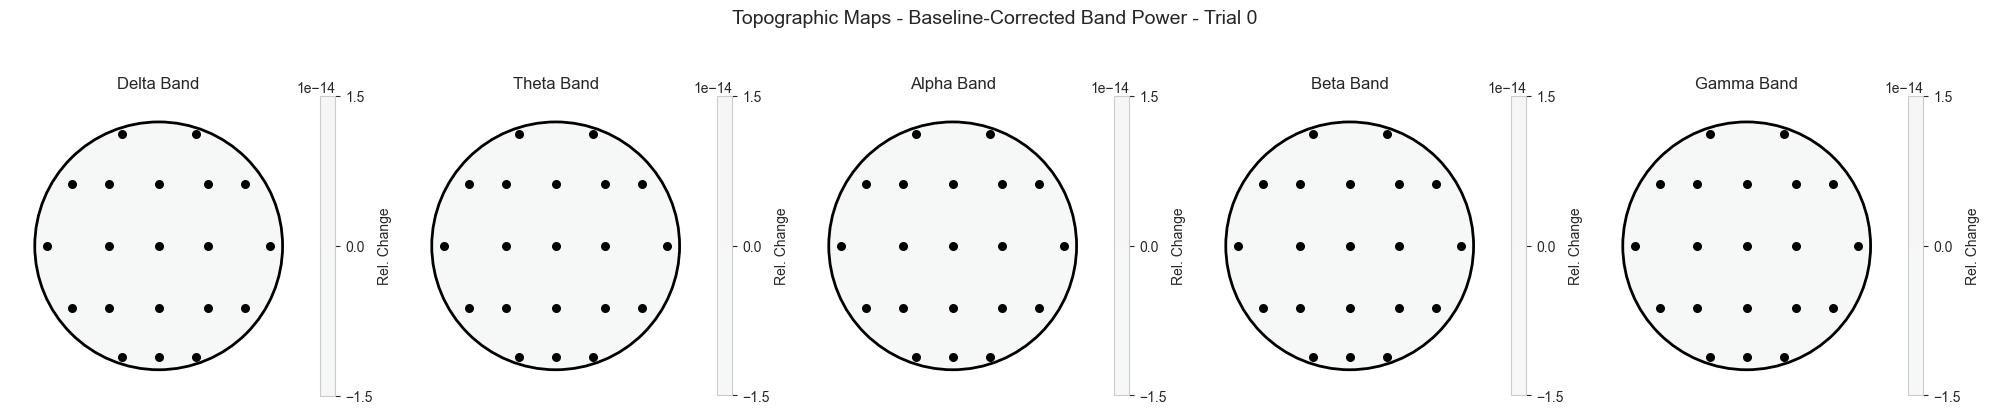

In [16]:
# Plot topographic maps for each frequency band
from scipy.interpolate import griddata

fig, axes = plt.subplots(1, 5, figsize=(20, 4))

# Create interpolation grid
xi = np.linspace(-1, 1, 100)
yi = np.linspace(-1, 1, 100)
xi, yi = np.meshgrid(xi, yi)

for idx, (band_name, powers) in enumerate(bp_corrected.items()):
    ax = axes[idx]
    
    # Interpolate
    zi = griddata(positions, powers, (xi, yi), method='cubic', fill_value=0)
    
    # Mask outside head
    mask = xi**2 + yi**2 > 1
    zi[mask] = np.nan
    
    # Plot
    im = ax.contourf(xi, yi, zi, levels=15, cmap='RdBu_r', vmin=-1, vmax=1)
    ax.scatter(positions[:, 0], positions[:, 1], c='k', s=30, zorder=10)
    
    # Draw head outline
    circle = plt.Circle((0, 0), 1, fill=False, color='k', linewidth=2)
    ax.add_patch(circle)
    
    ax.set_xlim([-1.2, 1.2])
    ax.set_ylim([-1.2, 1.2])
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(f'{band_name} Band', fontsize=12)
    
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='Rel. Change')

plt.suptitle(f'Topographic Maps - Baseline-Corrected Band Power - Trial {trial_idx}', 
             fontsize=14, y=1.05)
plt.tight_layout()
plt.show()

## 9. Summary Statistics Across All Trials

In [17]:
# Extract features for all trials
def extract_eeg_features_all(eeg_df, fs=256):
    """
    Extract band power features for all trials.
    
    Returns:
        features_df: DataFrame with columns for each band × channel combination
    """
    features_list = []
    
    for idx, row in eeg_df.iterrows():
        review_eeg = np.array(row['review_eeg'])
        baseline_eeg = np.array(row['baseline_eeg'])
        
        # Compute band powers
        bp_review = compute_band_power(review_eeg, fs)
        bp_baseline = compute_band_power(baseline_eeg, fs)
        
        # Baseline-correct
        # Create composite trial_id to match extracted_features.pkl format: "trialnum_subject_id"
        trial_features = {
            'subject_id': row['subject_date_id'],  # Rename to match extracted_features.pkl
            'trial_id': f"{row['trial_id']}_{row['subject_date_id']}"  # Composite key
        }
        
        for band_name in freq_bands.keys():
            bp_corr = (bp_review[band_name] - bp_baseline[band_name]) / (bp_baseline[band_name] + 1e-10)
            
            # Average by region
            for region, channels in channel_regions.items():
                ch_indices = [channel_names.index(ch) for ch in channels]
                avg_power = np.mean(bp_corr[ch_indices])
                trial_features[f'eeg_{band_name}_{region}'] = avg_power
        
        features_list.append(trial_features)
    
    return pd.DataFrame(features_list)

# Extract features
eeg_features_df = extract_eeg_features_all(eeg_df)

print(f"Extracted EEG features: {eeg_features_df.shape}")
print(f"\nFeature columns:")
print([c for c in eeg_features_df.columns if c.startswith('eeg_')][:10])
print(f"... total {len([c for c in eeg_features_df.columns if c.startswith('eeg_')])} features")
print(f"\nFirst few rows:")
print(eeg_features_df.head())

Extracted EEG features: (1287, 22)

Feature columns:
['eeg_Delta_Frontal', 'eeg_Delta_Central', 'eeg_Delta_Parietal', 'eeg_Delta_Occipital', 'eeg_Theta_Frontal', 'eeg_Theta_Central', 'eeg_Theta_Parietal', 'eeg_Theta_Occipital', 'eeg_Alpha_Frontal', 'eeg_Alpha_Central']
... total 20 features

First few rows:
          subject_id             trial_id  eeg_Delta_Frontal  \
0  0831_1300_9M4VCHG  0_0831_1300_9M4VCHG                0.0   
1  0831_1300_9M4VCHG  1_0831_1300_9M4VCHG                0.0   
2  0831_1300_9M4VCHG  2_0831_1300_9M4VCHG                0.0   
3  0831_1300_9M4VCHG  3_0831_1300_9M4VCHG                0.0   
4  0831_1300_9M4VCHG  4_0831_1300_9M4VCHG                0.0   

   eeg_Delta_Central  eeg_Delta_Parietal  eeg_Delta_Occipital  \
0                0.0                 0.0                  0.0   
1                0.0                 0.0                  0.0   
2                0.0                 0.0                  0.0   
3                0.0                 0.0      

In [18]:
# Summary statistics
eeg_cols = [c for c in eeg_features_df.columns if c.startswith('eeg_')]

print("\n" + "="*70)
print("EEG FEATURE SUMMARY")
print("="*70)
print(eeg_features_df[eeg_cols].describe())


EEG FEATURE SUMMARY
       eeg_Delta_Frontal  eeg_Delta_Central  eeg_Delta_Parietal  \
count             1287.0             1287.0              1287.0   
mean                 0.0                0.0                 0.0   
std                  0.0                0.0                 0.0   
min                  0.0                0.0                 0.0   
25%                  0.0                0.0                 0.0   
50%                  0.0                0.0                 0.0   
75%                  0.0                0.0                 0.0   
max                  0.0                0.0                 0.0   

       eeg_Delta_Occipital  eeg_Theta_Frontal  eeg_Theta_Central  \
count               1287.0             1287.0             1287.0   
mean                   0.0                0.0                0.0   
std                    0.0                0.0                0.0   
min                    0.0                0.0                0.0   
25%                    0.0         

## 10. Save Extracted Features

In [19]:
# Save extracted EEG features
output_path = '../data/results/eeg_features.pkl'
Path(output_path).parent.mkdir(parents=True, exist_ok=True)

with open(output_path, 'wb') as f:
    pickle.dump({
        'eeg_features_df': eeg_features_df,
        'feature_columns': eeg_cols,
        'metadata': {
            'n_trials': len(eeg_features_df),
            'n_features': len(eeg_cols),
            'frequency_bands': freq_bands,
            'regions': list(channel_regions.keys()),
            'sampling_rate': fs,
            'channel_names': channel_names
        }
    }, f)

print(f"✓ Saved EEG features to {output_path}")
print(f"  {len(eeg_features_df)} trials")
print(f"  {len(eeg_cols)} features")

✓ Saved EEG features to ../data/results/eeg_features.pkl
  1287 trials
  20 features
